<span>
<b>Author:</b> <a href="http://about.giuliorossetti.net">Giulio Rossetti</a><br/>
<b>Python version:</b>  >=3.7<br/>
<b>Networkx version:</b>  >=2.3<br/>
<b>Last update:</b> 24/02/2021
</span>

<a id='top'></a>
# *Chapter 7: Macro: Assortativity & Resilience*

In this notebook are introduced some of the main analysis discussed in lecture 7.

**Note:** this notebook is purposely not 100% comprehensive, it only discusses the basic things you need to get started. 

In [1]:
import networkx as nx
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

%matplotlib inline

Reading Game of Thrones Season 6 edge data and defining the graph g (useful for further operations)

In [2]:
def read_net_w(filename):
    g = nx.Graph()
    with open(filename) as f:
        f.readline()
        for l in f:
            l = l.split(",")
            g.add_edge(l[0], l[1], weight=int(l[2]))
    return g

# Game of Thrones data
season = 6
g = read_net_w(f'data/asioaf/got-s{season}-edges.csv')

houses = {}
with open(f'data/asioaf/got-s{season}-nodes_ext.csv') as f:
    f.readline()
    for l in f:
        node, _, house = l.rstrip().split(",")
        g.add_node(node, house=house)

## Assortative Mixing

**Homophily** Property of (social) networks that nodes of the same attitude tends to be connected with
a higher probability than expected

It appears as correlation between vertex properties of x(i) and x(j) if (i,j) ∈ E


**Disassortative mixing:**
Contrary of homophily: dissimilar nodes tend to be connected 
(e.g., sexual networks, predator-prey)

### Network wide (global) Assortativity measures

#### Newman's Assortativity

Quantify homophily while scalar node properties are involved (e.g., degree)

*Degree assortative*
- Nodes tends to connect homogeneously w.r.t. their degree (e.g., hubs with hubs)

*Degree disassortative*
- Nodes tends to connect in a star-like topology


In [3]:
nx.degree_assortativity_coefficient(g)

-0.006283179316286868

#### KNNK

*What's the expected neighbors' degree of a node given its degree?*

In [4]:
knn = nx.average_degree_connectivity(g) #calculate the average nearest neighbor degree of nodes with degree k.
knn = dict(sorted(knn.items()))

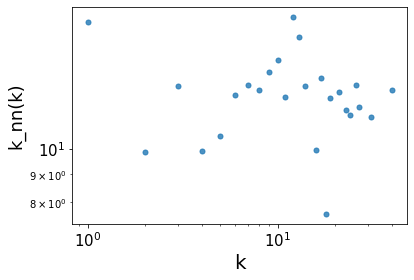

In [5]:
plt.plot(list(knn.keys()), list(knn.values()), '.', ms=10, alpha=0.8)
plt.loglog()
plt.xlabel("k", fontsize=20)
plt.ylabel("k_nn(k)",fontsize=18)
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.show()

#### Newman Assortativity on node properties

Same as the standard Newman's assortativity but computed on semantic information attached to nodes (e.g., labels)

In [6]:
nx.attribute_assortativity_coefficient(g, 'house')

0.20747480547396627

## Network Resilience
In the following we:
- generate Random and Scale-free Network
- compute Reslience for both Networks (through molloy_reed and breakdown_threshold)
- plot Game of Thrones graph Resilience under Random Failure and Targeted Attacks

Generating Networks

In [7]:
# Random
er = nx.erdos_renyi_graph(1000, 0.001)
# Scale-free
ba = nx.barabasi_albert_graph(1000, 2)

Computing node degree for both ER and BA Networks

In [8]:
er_degs = list(dict(er.degree()).values())
ba_degs = list(dict(ba.degree()).values())

Defining Molloy-Reed threshold

In [9]:
def molloy_reed(degrees):
    return (np.mean(degrees)*(np.mean(degrees)+1))/np.mean(degrees)

def breakdown_threshold(degrees):
    K = molloy_reed(degrees)
    return 1 - (1/(K-1))

Random network

In [10]:
molloy_reed(er_degs)

2.072

In [11]:
breakdown_threshold(er_degs)

0.0671641791044777

Scale-free network

In [12]:
molloy_reed(ba_degs)

4.992

In [13]:
breakdown_threshold(ba_degs)

0.7494989979959921

### Random Failures

In [14]:
def random_node(g): # select a random node from graph
    return [np.random.choice(g.nodes())]

def dismantle(g, function, **args): # incrementally removes node from a graph and computes size of connected components
    total_nodes = g.number_of_nodes()
    removed_nodes = []
    components = []
    while len(g.nodes()) > 1:
        n = function(g, **args)[0]
        g.remove_node(n)
        removed_nodes.append((len(removed_nodes)+1)/total_nodes)
        comps = list(nx.connected_components(g))
        g_size = 0
        if len(comps)>0:
            g_size  = max([len(c)for c in comps])/total_nodes
        components.append(g_size)
    return removed_nodes, components

def get_sorted_nodes(g, score, reverse=True): # sort nodes
    nodes = score(g)
    if isinstance(nodes, dict):
        nodes = [(k, v) for k, v in nodes.items()]
    srt = sorted(nodes, key = lambda k: k[1], reverse = reverse)
    return [x[0] for x in srt]

def plot_dismantle(x, y):
    plt.plot(x, y)
    plt.xlabel("Removed Nodes")
    plt.ylabel("Giant Component size")
    plt.show()

Random Failure:
- Giant component size has a consistent decrease when a big fraction of nodes is removed

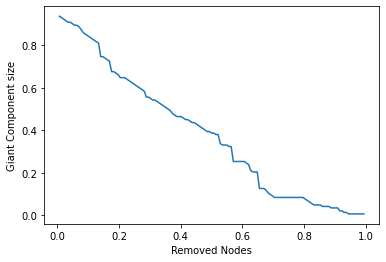

In [15]:
h = g.copy()
rn, comps = dismantle(h, random_node)
plot_dismantle(rn, comps)

### Targeted Attacks

Targeted Node attack (hubs are removed first)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

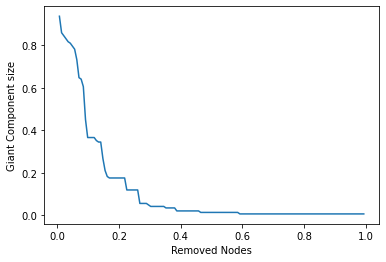

In [16]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.degree)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Betweenness Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

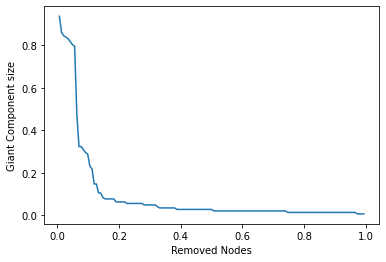

In [17]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.betweenness_centrality)
plot_dismantle(rn, comps)

Targeted Edge Attack (based on Edge Harmonic Centrality)
- Giant component size has a consistent decrease when a small fraction of nodes is removed

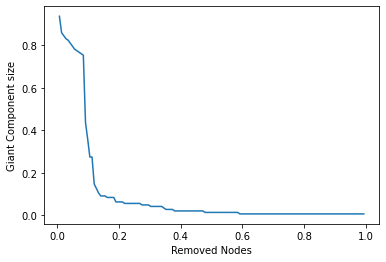

In [18]:
h = g.copy()
rn, comps = dismantle(h, get_sorted_nodes, score=nx.harmonic_centrality)
plot_dismantle(rn, comps)